In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.layers import Input, Dense, LSTM, Embedding, \
Dropout, Activation, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant


# !pip install -q -U keras-tuner
# import kerastuner as kt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from IPython.display import display

import re

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, predict_grade, separate_sentences, prepare_text

import spacy
!python -m spacy download en_core_web_lg
import en_core_web_lg



pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=fa1c798fdf7d2d6ddd04195473dc870a2228e0e5c96a86b44e36f3cd19ebe7cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ra_jw5pd/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# The Data
the data consists of anonymized essays and stories written by students in grades kindergarten through high school.  We've collected these from around the web.  Let's look at some statistics below.

## Alternative Grouping
We removed samples from grades K (0) and 1 because we suspect most of them were dictated and transcribed by teachers.  They don't seem to be representative of independent writing skills.

We also combined all high school grades to 12.  Previous iterations of the model did not do well distinguishing between high school level texts.  We changed them to 12 because later we want the model to use the average of sentences to predict the grade of a longer text.  The model will almost never predict 12 because an average will always bring it down.

lemmatize

In [5]:
sp = en_core_web_lg.load()
full_df = load_text()


In [6]:
df = full_df[full_df.Grade > 1]

X = df.Text
y = df.Grade

train = pd.DataFrame(columns = ['Grade','Text'])
test = pd.DataFrame(columns = ['Grade','Text'])

train['Text'], test['Text'], train['Grade'], test['Grade'] = train_test_split(X, y, random_state=111)
train = separate_sentences(train)
train = prepare_text(train, sp)

X_t, X_val, y_t, y_val = train_test_split(train.drop(columns = 'Grade'), train.Grade, random_state=111)

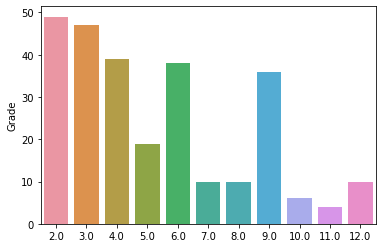

In [7]:
sns.barplot(x=df.Grade.unique(), y=df.Grade.value_counts())

You can see above that we have a large imbalance in grades represented.  It's tempting to cluster grades together, but we want a tool that predicts with some specificity.  Here's a lesson from my teaching years, however:  Most kids don't write sentences on their own in Kindergarten.  Looking over our texts for Kindergarten and first grade, these seem to be dictated and transcribed by an adult.  

In model development we also saw that high school texts are difficult to classify accurately as well.  For these reasons, we clump all high school and K-2nd grade together.  

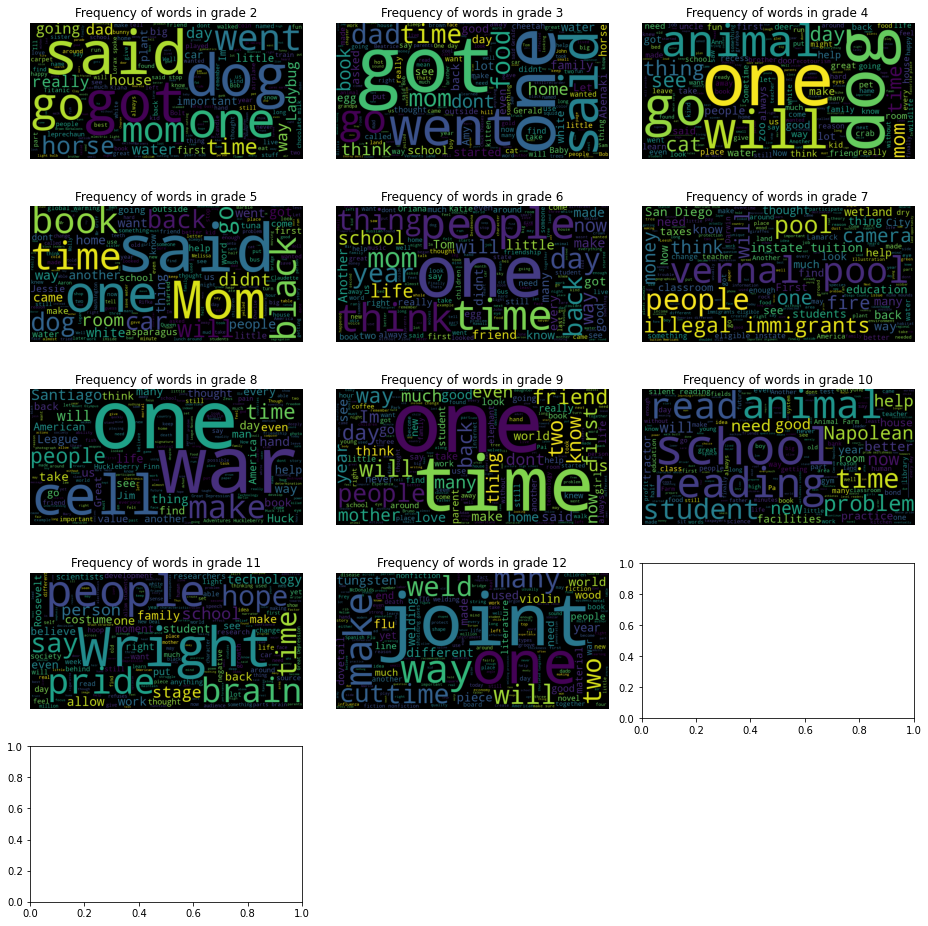

In [8]:
fig, axes = plt.subplots(4,3, figsize = (13,13))
axes=axes.ravel()
grades = sorted(df.Grade.unique())
for i, grade in enumerate(grades):
    text = ' '.join([story for story in df.loc[df.Grade == grade, 'Text']])
    axes[i].imshow(WordCloud(width=800, height=400).generate(text))
    axes[i].set_title(f'Frequency of words in grade {int(grade)}')
    axes[i].axis('off')
fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig('word_clouds.png', dpi=200)
plt.show()
    

# FSM
How accurate would we be if we just predict all samples will be the median grade of the training set?  This can be our baseline model.

In [9]:
FSM = np.array([y_t.median()] * len(y_val))
FSM_MAE = np.sum(np.abs(y_val - FSM))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)

Baseline MAE is:  2.518727552591072


So, that means our model has to beat 2.5 MAE to have any predictive power.

# TF-IDF Vectorization

TF-IDF vectorization represents each word with a float representing its relative specificity to a given document.  The random forest model, however, is non-sequential.  It looks at each sentence as a collection of words.  Therefor the above power represents the opportunity to judge writing level purely by vocabulary used.

I'd like to have longer input sequences after vectorizing and padding than my longest sentence.  

In [18]:
col = 'Lemmas'
Vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=None)
Vectorizer.adapt(X_t[col].to_numpy())
print(col)

X_t_tfidf = Vectorizer(X_t[col])
X_val_tfidf = Vectorizer(X_val[col])
    
X_t_tfidf

Lemmas


<tf.Tensor: shape=(5846, 6672), dtype=float32, numpy=
array([[0.       , 1.8113958, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.7170937, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.7170937, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.9056979, 1.1789807, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.9056979, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

Lemmas

# Linear Regression

Let's see how far we can get with the simplest of linear predictive models based on the vocabulary in the text.

In [19]:
lr_reg = LinearRegression().fit(X_t_tfidf, y_t)
yhat = lr_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for Linear Regression on TF-IDF vectors = ', mae)


Baseline MAE is:  2.518727552591072
MAE for Linear Regression on TF-IDF vectors =  11637.13994074247


The linear regression slightly beat predicting the median, but not by a lot.

# XGBoost

In [20]:
from xgboost import XGBRegressor
XGB_reg = XGBRegressor().fit(X_t_tfidf, y_t)
yhat = XGB_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for XGBoost TF-IDF vectors = ', mae)

[19:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline MAE is:  2.518727552591072
MAE for XGBoost TF-IDF vectors =  2.236192827043685


XGBoost did not seem to improve much.


## Shallow Model development opportunities:
My goal in this project is to explore deep learning NLP approaches, so I did not spend a lot of time tuning the traditional models.  I include them more as reference and justification for models that require greater computational resources.

Opportunities:

1. Hyperparameter tuning of traditional models

# Deep Models

I wonder if a model that explores the grammar and semantic relationships between words within the student writing samples might have greater insight into stages of writing development?  



# TextVectorization

We used TextVectorization as TF-IDF encoder above, but it can also be used as a Keras model layer.  I create a new TextVectorization object with appropriate sequence lengths for padding.  Each word will be encoded as an integer and sentences will be arrays of integers.

# Word Embedding

My first choice, in order to preserve some of the semantic relationships between the words I used word embeddings, rather than TF-IDF, to vectorize my texts.  This is a very different approach and, in fact, whereas in many other vectorization strategies each word is represented by a single number, word embeddings encode each word as a high dimensional vector array.  That means that a sentence becomes a 2D matrix.  

We don't encode the texts as such yet, but we do need to create a reference matrix to translate word encodings to their matching embedding vector.  Now Keras provides trainable embedding layers that learn along with the other layers of your model.  They contain huge numbers of weights depending on the size of your vocabulary and embedding length.

However, there are several libraries of pre-trained word embeddings that can be loaded.  I use the SpaCy NLP package to create a word embedding matrix as a 2D matrix.  The indices will be the keys and the matching row will be the embedding.  These integers match the encoding that the TextVectorization layer uses.

This matrix can then be loaded in as the weights of a Keras Embedding layer.  Remember to set `trainable=False`. The model will use the Embedding layer to cross-reference each word in the sentence.  These embeddings will suggest word relationships and will be read in order by the next layer, the Long-Short Term Memory layer.

Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 for the below code to create the weights matrix:

In [21]:
# Establish sequence length.  Set here as the longest sentence in the training set.
X_train = train[col]
y_train = train.Grade
longest_sentence = X_train.str.len().max()

# Instantiate and fit the vectorizing layer.  
# We can use this as a transformer, a vocabulary, and a layer in our model.
Vectorizer = TextVectorization(output_sequence_length=longest_sentence, max_tokens=2000)
Vectorizer.adapt(X_train.to_numpy())
vocab = Vectorizer.get_vocabulary()

# Load the SpaCy model as 'nlp'
nlp = sp
#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

# Hybrid Bi-directional
We are going to pull out all the guns here and use a bi-directional LSTM with that pre-trained SpaCy embedding layer.  We are going to throw that on top of a deep densely connected network with a global max pool layer between them.

The data comes in at the input layer and to the vectorizing layer which translates them into uniform length integer arrays.  Those arrays are are expanded into a 2D matrix in the Embedding layer.  The LSTM layer then reads the embeddings in the order they originally appeared in the text and makes choices about them.  This is a learned skill.  The bidirectional wrapper sends the text embedding both forward and backward through the layer and concatenates the output sequences together.  The GlobalMaxPooling1D layer reduces the dimensionality back down to pass to the densely connected layers.

The model then outputs a float which represents its guess at the grade level of the author of a text.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 396)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 396, 300)          600000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 396, 200)          320800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 2/60
63/63 [==============================] - 5s 81ms/step - loss: 3.0825 - val_loss: 3.3836

Epoch 00002: val_loss did not improve from 3.07954
Epoch 3/60
63/63 [==============================] - 5s 81ms/step - loss: 2.7656 - val_loss: 3.1960

Epoch 00003: val_loss did not improve from 3.07954
Epoch 4/60
63/63 [==============================] - 5s 80ms/step - loss: 2.5976 - val_loss: 3.1733

Epoch 00004: val_loss did not improve from 3.07954
Epoch 5/60
63/63 [==============================] - 5s 80ms/step - loss: 2.4115 - val_loss: 2.8760

Epoch 00005: val_loss improved from 3.07954 to 2.87601, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 6/60
63/63 [==============================] - 5s 81ms/step - loss: 2.2837 - val_loss: 2.8125

Epoch 00006: val_loss improved from 2.87601 to 2.81254, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 7/60
63/63 [==============================] - 5s 80ms/step - loss: 2.2290 - val_loss: 2.8221

Epoch 00007: val_loss did not improve from 2.81254
Epoch 8/60
63/63 [==============================] - 5s 80ms/step - loss: 2.1767 - val_loss: 2.5845

Epoch 00008: val_loss improved from 2.81254 to 2.58454, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 9/60
63/63 [==============================] - 5s 80ms/step - loss: 2.1277 - val_loss: 2.6774

Epoch 00009: val_loss did not improve from 2.58454
Epoch 10/60
63/63 [==============================] - 5s 81ms/step - loss: 2.0787 - val_loss: 2.7525

Epoch 00010: val_loss did not improve from 2.58454
Epoch 11/60
63/63 [==============================] - 5s 81ms/step - loss: 2.0222 - val_loss: 2.5580

Epoch 00011: val_loss improved from 2.58454 to 2.55800, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 12/60
63/63 [==============================] - 5s 81ms/step - loss: 1.9395 - val_loss: 2.5751

Epoch 00012: val_loss did not improve from 2.55800
Epoch 13/60
63/63 [==============================] - 5s 81ms/step - loss: 1.8733 - val_loss: 2.3918

Epoch 00013: val_loss improved from 2.55800 to 2.39184, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 14/60
63/63 [==============================] - 5s 81ms/step - loss: 1.8701 - val_loss: 2.3286

Epoch 00014: val_loss improved from 2.39184 to 2.32855, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 15/60
63/63 [==============================] - 5s 81ms/step - loss: 1.8196 - val_loss: 2.3093

Epoch 00015: val_loss improved from 2.32855 to 2.30928, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 16/60
63/63 [==============================] - 5s 81ms/step - loss: 1.8110 - val_loss: 2.2934

Epoch 00016: val_loss improved from 2.30928 to 2.29345, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 17/60
63/63 [==============================] - 5s 81ms/step - loss: 1.7373 - val_loss: 2.4723

Epoch 00017: val_loss did not improve from 2.29345
Epoch 18/60
63/63 [==============================] - 5s 81ms/step - loss: 1.7501 - val_loss: 2.2456

Epoch 00018: val_loss improved from 2.29345 to 2.24560, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 19/60
63/63 [==============================] - 5s 81ms/step - loss: 1.7116 - val_loss: 2.2335

Epoch 00019: val_loss improved from 2.24560 to 2.23352, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 20/60
63/63 [==============================] - 5s 81ms/step - loss: 1.7024 - val_loss: 2.2162

Epoch 00020: val_loss improved from 2.23352 to 2.21619, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 21/60
63/63 [==============================] - 5s 81ms/step - loss: 1.6431 - val_loss: 2.1569

Epoch 00021: val_loss improved from 2.21619 to 2.15692, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 22/60
63/63 [==============================] - 5s 81ms/step - loss: 1.7179 - val_loss: 2.3391

Epoch 00022: val_loss did not improve from 2.15692
Epoch 23/60
63/63 [==============================] - 5s 81ms/step - loss: 1.6378 - val_loss: 2.1512

Epoch 00023: val_loss improved from 2.15692 to 2.15123, saving model to model-BiLSTM-MLP-hybrid


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 24/60
63/63 [==============================] - 5s 82ms/step - loss: 1.6292 - val_loss: 2.1761

Epoch 00024: val_loss did not improve from 2.15123
Epoch 25/60
63/63 [==============================] - 5s 81ms/step - loss: 1.5648 - val_loss: 2.2575

Epoch 00025: val_loss did not improve from 2.15123
Epoch 26/60
63/63 [==============================] - 5s 81ms/step - loss: 1.5514 - val_loss: 2.3118

Epoch 00026: val_loss did not improve from 2.15123
Epoch 27/60
63/63 [==============================] - 5s 81ms/step - loss: 1.5174 - val_loss: 2.2742

Epoch 00027: val_loss did not improve from 2.15123
Epoch 28/60
63/63 [==============================] - 5s 81ms/step - loss: 1.4925 - val_loss: 2.1960

Epoch 00028: val_loss did not improve from 2.15123
Epoch 29/60
63/63 [==============================] - 5s 81ms/step - loss: 1.4665 - val_loss: 2.2694

Epoch 00029: val_loss did not improve from 2.15123
Epoch 30/60
63/63 [==============================] - 5s 82ms/step - loss: 1.4415 - val_l

INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 35/60
63/63 [==============================] - 5s 81ms/step - loss: 1.3625 - val_loss: 2.1471

Epoch 00035: val_loss did not improve from 2.14163
Epoch 36/60
63/63 [==============================] - 5s 81ms/step - loss: 1.3554 - val_loss: 2.2564

Epoch 00036: val_loss did not improve from 2.14163
Epoch 37/60
63/63 [==============================] - 5s 81ms/step - loss: 1.3462 - val_loss: 2.1839

Epoch 00037: val_loss did not improve from 2.14163
Epoch 38/60
63/63 [==============================] - 5s 81ms/step - loss: 1.3413 - val_loss: 2.2231

Epoch 00038: val_loss did not improve from 2.14163
Epoch 39/60
63/63 [==============================] - 5s 82ms/step - loss: 1.3415 - val_loss: 2.1467

Epoch 00039: val_loss did not improve from 2.14163
Epoch 40/60
63/63 [==============================] - 5s 82ms/step - loss: 1.3085 - val_loss: 2.1724

Epoch 00040: val_loss did not improve from 2.14163
Epoch 41/60
63/63 [==============================] - 5s 82ms/step - loss: 1.2938 - val_l

INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid/assets


Epoch 60/60
63/63 [==============================] - 5s 82ms/step - loss: 1.0833 - val_loss: 2.1493

Epoch 00060: val_loss did not improve from 2.13542


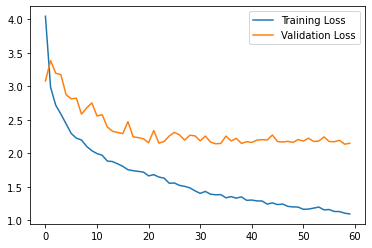

In [22]:

filepath = 'model-BiLSTM-MLP-hybrid'
def make_BiLSTM():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(Vectorizer)
    model.add(Embedding_layer)
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = make_BiLSTM()
print(model.summary())
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_format='tf'
                             )
callbacks = [checkpoint]

history = model.fit(X_train,
            y_train,
            epochs=60,
            batch_size=100,
            validation_split = .2,
            verbose=1,
            callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Model Evaluation
This model takes forever to train.  While having a frozen embedding layer helps reduce the number of weights to update, you'll want to train this on something with a good CUDA GPU.  It scores a 1.7 grade level average error, quite a bit better than the FSM accuracy of 2.5.  

In [23]:
filepath = 'model-BiLSTM-MLP-hybrid'
model = keras.models.load_model(filepath)
yhat = model.predict(test.Text).ravel()
print('MAE = ', np.sum(np.abs(test.Grade-yhat))/len(test.Grade))
print('STD of errors: ', np.abs(test.Grade - yhat).std())
print('mean grade prediction = ', np.mean(yhat))
print('mean grade = ', np.mean(test.Grade))

errors = pd.DataFrame()
errors['Text'] = test.Text
errors['Grade'] = test.Grade
errors['Predicted Grade'] = yhat
errors.sample(5)

MAE =  2.6774836725263453
STD of errors:  1.874707022421837
mean grade prediction =  8.20791
mean grade =  5.970149253731344


,Text,Grade,Predicted Grade
127,Oh my God I exclaimed Whats John doing out there? Why is he on his hands and knees Mom? I looked out the big kitchen window wondering if my eight year old brother was all right. He was on hands and knees in our back yard looking rather distressed. Then he threw up. I ran out to see what happened. John stood up and smiled. I was panicked. You have to come inside now! What happened?! I asked almost screaming. I ate too much at breakfast. I want to keep playing. Im not sick Ellie! He pouted at me for the next five minutes until agreeing to come inside with me or as I threatened mom would be mad. The minute we got inside he started acting like an angel. Little brat. I thought. I hate him. This typical incident was just yesterday but I can still remember the morning of March 2nd 1969 a day that has affected my life more than I ever could have suspected. To me a five year old girl it seemed pretty simple: Mom was having a baby. I couldnt comprehend the implications this would have on my life. When I woke up that morning I went downstairs to demand breakfast but instead grandma was there and said bluntly Your moms at the hospital having the baby. Oh I thought completely unaffected. I called my friend Jakie who lived across the yard to come over and play. Jakie was my best friend and she flipped out wondering about the baby and what was going on. Then I started to get curious about it too. My sister who had already gone through the birth of a younger sibling (me!) seemed less than enthusiastic. I started to miss my mom something that had rarely happened before. When Coral my mom and Dads closest friend pulled up in our driveway everyone told me that we were going to the hospital to see my mom and my new brother. I felt my first pangs of jealousy. We all ran to see my mom who had been in labor all night. I jumped right into the bed next to my exhausted mother as soon as we got into her room. My brother was being weighed and measured but we got to hold him soon. I was secretly scared because he was so small and delicate. He looked sort of gross but everyone else seemed to love him so I didnt say anything. You could barely see his face because of all the wrinkles. Gross! I thought in disgust! His whole body was covered in wrinkles and he was on the redish side. We decided to call him John Jordan Strosahl. John (now Johnny-Jordan) grew up to be a superbly cute baby â€” to my disappointment. He had golden blonde baby curls spilling off his head which reminded me of the foam on a coke. Big round sapphire eyes lit up his face â€” as if he need it with such a great big gummy smile. Thats what has bugged me most for all these years. Frankly John was the cutest baby and I knew that the amount of doting time we got wasnt equal; this made me pretty mad.,6.0,8.580693
206,Dear Teachers I have recently begun learning about the Shut Down Your Screen week. This is a program where kids in school and out of school dont use any electronics for one week. Everyone in your school would participate. This is a way to save the way we think and try something new. My question is should we participate in the national Shut Down Your Screen Week? I think it would be a good idea for many reasons. First I think we should participate because using too much technology affects the way we think and behave. In the article Attached to Technology and Paying a Price by Matt Richtel it gives many scientifically proven facts that using technology too much affects the way we think. If you are juggling e-mail phone calls and other incoming information it can lose peoples focus. Also as the text states The stimulation provokes excitement that researchers say can be addictive. In its absence people feel bored. This means that people can become addicted and when not using technology become bored with things they used to love to do. Another reason I think we should participate in this program is because using technology while doing something else (mul

# Sentence Average Grade Approach

In order to create more data to train on we split samples into individual sentences while retaining the original grade label for each one.  New texts then will also be broken down into sentences, individual predictions are made on each sentence, and the model returns the mean average grade level prediction over all sentences. 

This approach was to combat previous bias in our models toward longer texts being higher grades, to create more data, and to reduce the size of input sequences.  Some of the texts are several pages long.  This also somewhat helped the class imbalance because the older students, which we had fewer of, also wrote texts with more sentences.  

Finally, it can take advantage of the 'Wisdom of the Crowds' effect to improve the accuracy on longer texts.

`predict_grade()` splits the input text into sentences, uses the input model to make predictions on each one, then returns the mean average of the sentences level predictions as the prediction for the entire text.

In [24]:
# model = load_model('model-BiLSTM-MLP-hybrid')
errors = test.copy().reset_index(drop=True)
yhat = predict_grade(model, test.Text)
errors['average_prediction'] = yhat

print('MAE of average sentence predictor is: ', np.sum(np.abs(errors['Grade'] - errors['average_prediction']))/len(errors))
errors.sample(5)

MAE of average sentence predictor is:  2.2703845607700632


Grade  ... average_prediction
52    2.0  ...           7.220184
16    9.0  ...           7.864125
39    7.0  ...           8.087124
24    4.0  ...           6.629611
34    9.0  ...           8.218136

[5 rows x 3 columns]

The accuracy jumped from 1.8 grade levels average error to 1.4.  In other words, the longer the writing sample, the more accurate the model should be, at least up to a point.

Another note here is that while the model takes a long time to load, being almost a 1GB in size, the predictions aren't too slow.

# Conclusion
With a top accuracy of 1.4 grade levels average error, this model is probably not very useful to a teacher. There are many aspects that go into writing development and the small sample size of our data doesn't give enough.  While dividing texts by sentences raises our sample size from ~300 to ~10,000, there are still only 300 individual writers represented.  The component sentences in a document are going to be highly correlated to the writer and therefor offer less diverse information to the model than if all 10,000 were from independent sources.  

~300 is just not enough student writers to find the trends in the noise.  A dataset of 10,000 writing samples from young writers, labeled with their current grade of study, might be enough to return some very interesting insights and much more accurate predictions.  Ideally the writing samples would be selected as representing grade appropriate standards according to the CCSS.  If an accurate predictor could be created that would return the Common Core Standards aligned grade level of a writing, based on writing mechanics.

Our baseline model, simply the median of the training set predicted for every text, had an average accuracy of 2.6 grade levels on the validation set.  Traditional machine learning models, linear regression, random forest, and XGBoost improved on that a little by encoding the texts into TF-IDF vectors and fitting on them.  

We then tried vectorizing the texts using pre-trained word embedding vectors from the SpaCy large web collected word embedding dictionary.  We used a TextVectorization layer to first encode the words in the text into integers, which the model then used to look up the embeddings in the embedding layer.  This added a dimension to our data before it was passed into a bidirectional Long-Short Term Memory recurrent neural network layer.  The output sequence of that LSTM is flattened and passed through 10 layers of ever shrinking dense layers interspersed with dropout layers for regularization.

The output is a regression, not a classification.  It would be simple to make it a classification with rounding, though.  This is essentially what a sigmoid activation on the final layer would do anyway.

The model scores significantly better than both the median predictor and any of the shallow models.  While an accuracy of rough one and a half grade levels may not be good enough for use by teachers, it is proof that writing level CAN be predicted, at least to some degree.  

# Future Study
I recommend more study go into modeling writing development.  The greatest need, from what I could find, is in the collection and anonymization of labeled writing samples from K-12 students.  With a greater library of labeled samples I hypothesize that the model can achieve a precision within one grade level.

There are also many more modeling options that can be explored.  I've seen some architectures with convolutional layers.  

There are also many more opportunities for text preparation.  NLP is a complex art and tools abound.